Hi, in this short note I will present a very simple trick, which will help us to decide which variables to remove in the model because of too little importance on the explained variable (potentially variables that bring more noise to the model than information). The main source of inspiration to create this notebook was a video of [one of the competition grandmasters](https://www.kaggle.com/mchahhou), who presented this idea during Kaggle Days in Dubai in 2019. Link to this very interesting lecture in the links at the end of the notebook. It's worth learning from examples, so we will use the data from the April tabluar data competition, where, based on the data from the famous "Titanic" data set, I will show the logic of the idea, probably from this language R. It isn't about the code itself, but the idea behind it, because it allows you to better understand the impact of changes on the model and, as a result, allows you to create a better one. Enjoy reading!

In [1]:
library(tidyverse)
library(ggthemes)
library(caret)
library(randomForest)
set.seed(101)

options(warn = -1)
options(scipen = 10000)
options(repr.plot.width = 13.6, repr.plot.height = 9)

train <- read.csv("../input/tabular-playground-series-apr-2021/train.csv")
test <- read.csv("../input/tabular-playground-series-apr-2021/test.csv")

theme_michau <- theme(legend.position = "bottom", legend.direction = "horizontal", axis.text = element_text(size = 16.5), 
plot.caption = element_text(color = "gray55", size = 11.5), legend.text = element_text(size = 16), 
axis.title = element_text(size = 16.5, face = "bold", color = "gray25"), legend.title = element_text(size = 16), 
axis.line = element_line(size = 0.4), plot.title = element_text(size = 20), plot.subtitle = element_text(size = 16.5), 
strip.text = element_text(size = 16, face = "bold"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




<p align="justify">The principle of operation is very simple and can be described in several points. The first is to prepare the data for the model. We take the dataset and, if necessary, fill in the gaps or change the coding method and leave all the variables, however substantially related to the explained variable, in this case "Survived". I will not go into detail in this stage, there are many guides on how to do it. First, we will get rid of the completely useless variables, which is the passenger's ID, ticket and cabin number and his name and surname, which have no effect on whether or not he survived the catastrophe. The gender, which is a qualitative feature, will be introduced as a zero-one variable. I will introduce the variable about embarkation having three levels as 3 separate zero-one variables. Missing data in the variable about the passenger's age and fare will be filled in using a simple method of imputation with the median.</p>

In [2]:
train <- train[ ,-which(names(train) %in% c("PassengerId", "Name", "Ticket", "Cabin"))]
test <- test[ ,-which(names(test) %in% c("PassengerId", "Name", "Ticket", "Cabin"))]

train$Sex <- ifelse(train$Sex=="male", 0 ,1)
test$Sex <- ifelse(train$Sex=="male", 0 ,1)

train_Emb <- dummyVars(~Embarked, data = train, fullRank = F)
train_Emb <- as.data.frame(predict(train_Emb, newdata = train))
train <- cbind(train, train_Emb)

test_Emb <- dummyVars(~Embarked, data = test, fullRank = F)
test_Emb <- as.data.frame(predict(test_Emb, newdata = test))
test <- cbind(test, test_Emb)

train$Age[is.na(train$Age)] <- median(train$Age, na.rm = T)
test$Age[is.na(test$Age)] <- median(test$Age, na.rm = T)

train$Fare[is.na(train$Fare)] <- median(train$Fare, na.rm = T)
test$Fare[is.na(test$Fare)] <- median(test$Fare, na.rm = T)

train <- train[ ,-which(names(train) %in% c("Embarked.", "Embarked"))]
test <- test[ ,-which(names(test) %in% c("Embarked.", "Embarked"))]

head(train)
head(test)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked.C,Embarked.Q,Embarked.S
,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0,39.00,2,0,27.14,0,0,1
2,0,3,0,39.00,0,0,13.35,0,0,1
3,0,3,0,0.33,1,2,71.29,0,0,1
4,0,3,0,19.00,0,0,13.04,0,0,1
5,1,3,0,25.00,0,0,7.76,0,0,1
6,0,2,0,35.00,0,0,6.71,0,0,1


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked.C,Embarked.Q,Embarked.S
,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,1,19,0,0,63.01,0,0,1
2,3,1,53,0,0,5.81,0,0,1
3,1,1,19,0,0,38.91,1,0,0
4,2,1,25,0,0,12.93,0,0,1
5,1,1,17,0,2,26.89,1,0,0
6,3,1,34,0,0,10.40,1,0,0


<p align="justify">We have successfully created a dataset that is ready for modeling. Variable engineering could already be carried out on this dataset, but some of the variables may turn out to be so insignificant in the explained survival that it makes no sense to consider it further. How to check? We add a random variable to the training set ... yes, completely random. I add a random number from 0 to 1 to each row of the dataset (they have no distribution, every digit between 0 and 1 has an equal chance of being drawn).</p>

In [3]:
train$Random <- runif(nrow(train))

<p align="justify">On such a prepared training set with pre-processed variables and an added variable with random numbers, we create a simple model. I choose an ordinary random forest with 100 trees without any optimization of the parameters (remembering that this is a classification, because the variable being explained is expressed on a nominal scale).</p>

In [4]:
model <- randomForest(as.factor(Survived)~., data = train, ntree = 100)
print(model)


Call:
 randomForest(formula = as.factor(Survived) ~ ., data = train,      ntree = 100) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 3

        OOB estimate of  error rate: 22.97%
Confusion matrix:
      0     1 class.error
0 45715 11511   0.2011498
1 11461 31313   0.2679431


<p align="justify">We managed to create a simple model that will be useful in further analysis. It isn't the final model or method, we only create it to check the importance of selected variables in the model. We extract this information from the model and create a plain bar chart. I chose mean decrease Gini as a measure of the influence of variables on the model.</p>

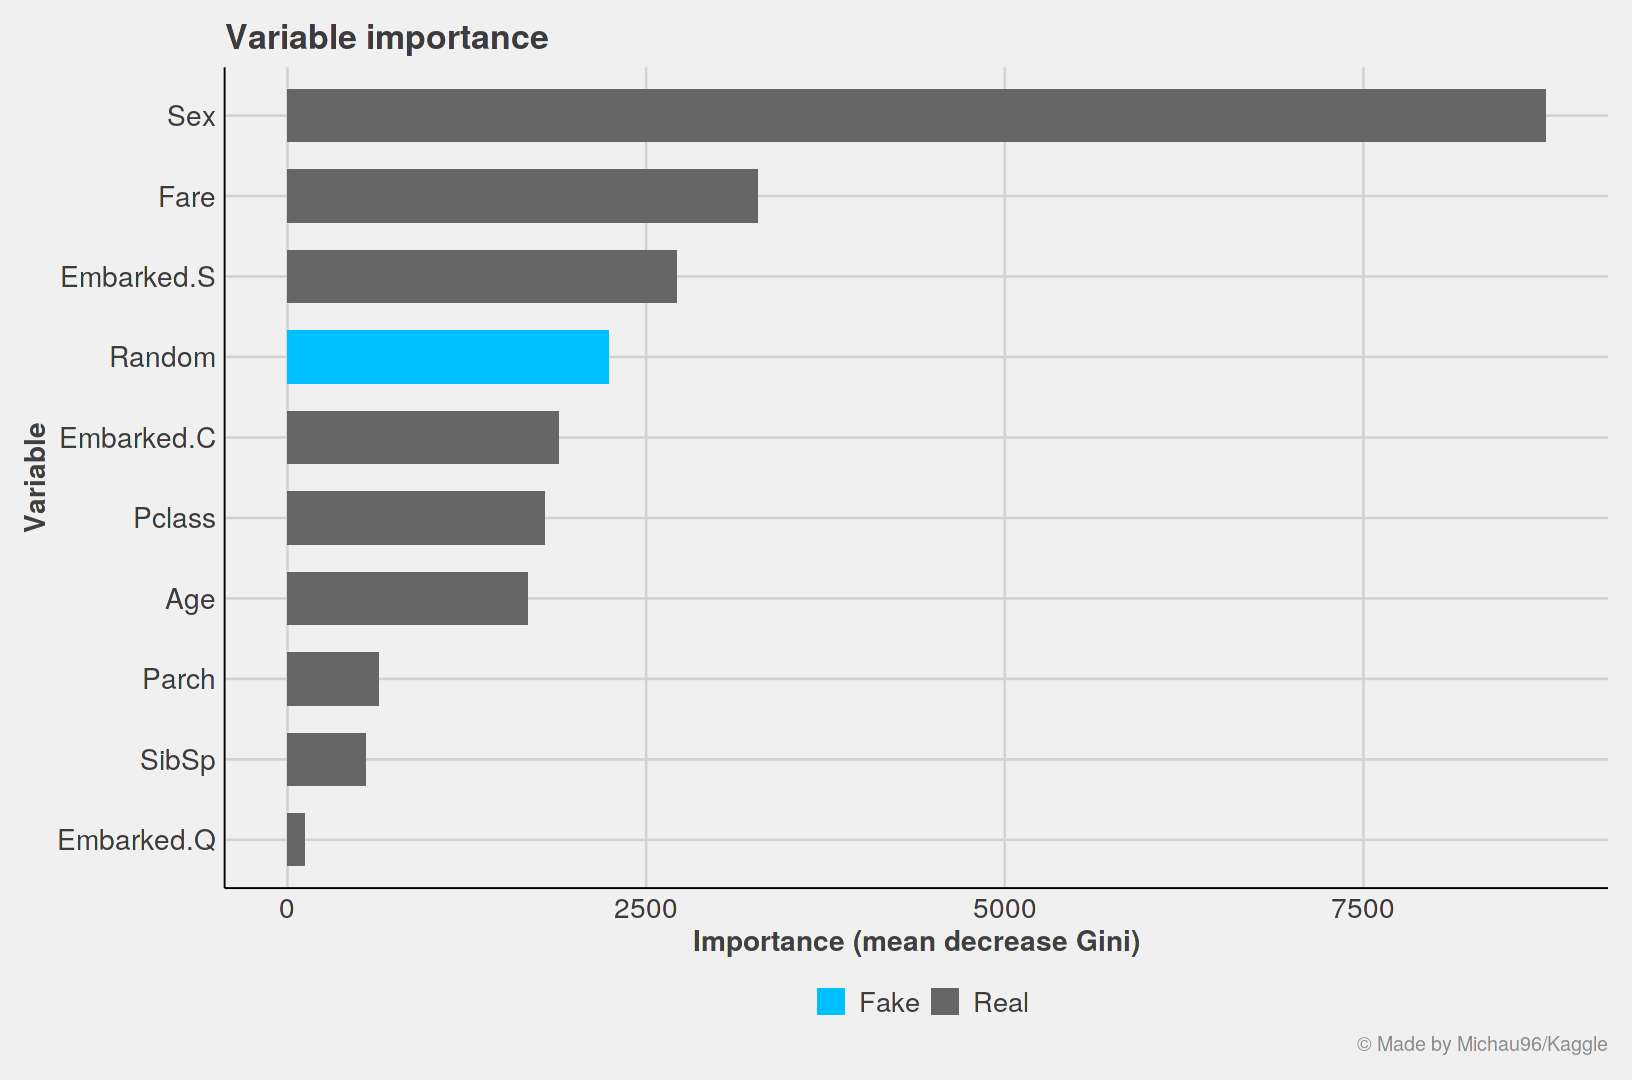

In [5]:
imp <- as.data.frame(model$importance)
imp$variable <- rownames(imp)
imp$isReal <- ifelse(imp$variable=="Random", "Fake", "Real")

ggplot(imp, aes(reorder(variable, +MeanDecreaseGini), MeanDecreaseGini, fill = isReal))+
  geom_bar(stat = "identity", width = 0.65)+
  scale_fill_manual(values = c("deepskyblue", "gray40"))+
  coord_flip()+
  labs(title = "Variable importance", fill = "",
       x = "Variable", y = "Importance (mean decrease Gini)", 
       caption = "© Made by Michau96/Kaggle")+
  theme_fivethirtyeight()+
  theme_michau

<p align="justify">And now the most important moment - we check what level of importance the added variable with random numbers has on the model. This variable is an obvious noise in the model, it doesn't provide any information and isn't related in any way to the analyzed dataset. Variables which in such a case have a smaller importance than this variable are not suitable in their current form for forecasting the dependent variable. On the other hand, the variables with a greater impact on the model than the random variable most likely have a positive impact on the model, as they explained the analysis variable to a greater extent than the random noise.</p>

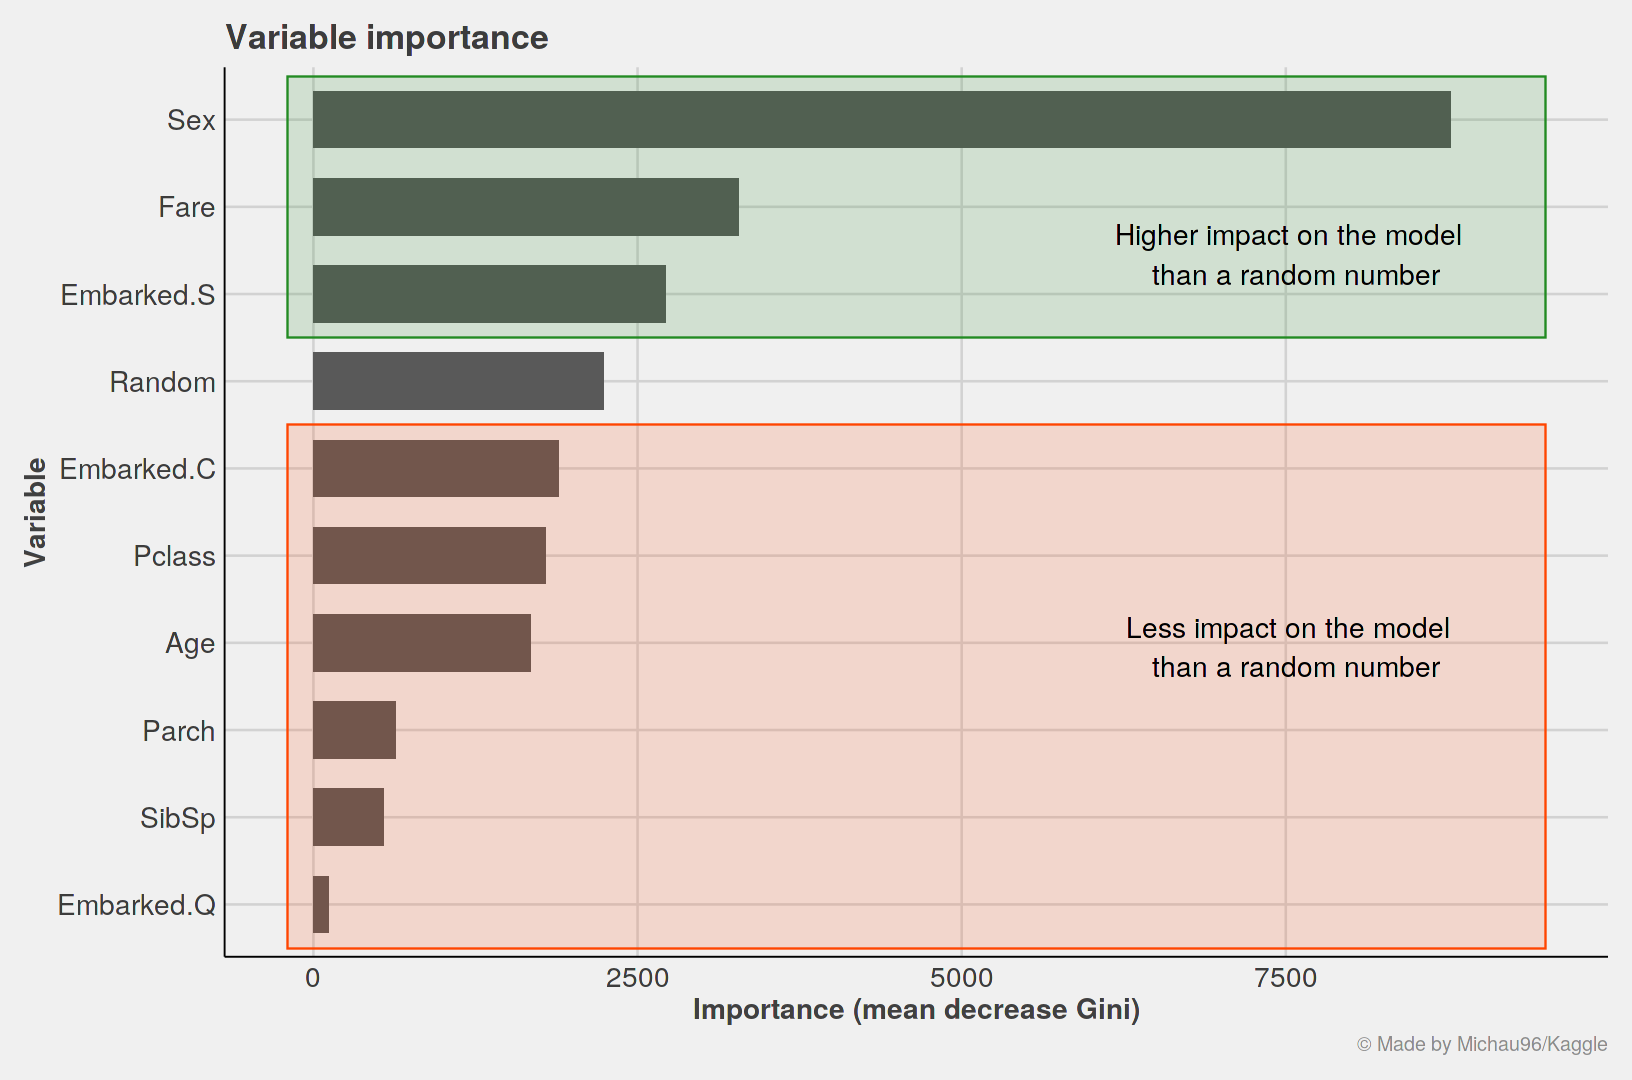

In [6]:
ggplot(imp, aes(reorder(variable, +MeanDecreaseGini), MeanDecreaseGini))+
  geom_bar(stat = "identity", width = 0.65)+
  coord_flip()+
  annotate("rect", xmin = 0.5, xmax = 6.5, ymin = -200, ymax = 9500, alpha = 0.15, color = "orangered", fill = "orangered")+
  annotate("rect", xmin = 7.5, xmax = 10.5, ymin = -200, ymax = 9500, alpha = 0.15, color = "forestgreen", fill = "forestgreen")+
  annotate("text", x = 3.95, y = 7550, label = "Less impact on the model \n than a random number", size = 5.8)+
  annotate("text", x = 8.45, y = 7550, label = "Higher impact on the model \n than a random number", size = 5.8)+
  labs(title = "Variable importance", fill = "",
       x = "Variable", y = "Importance (mean decrease Gini)", 
       caption = "© Made by Michau96/Kaggle")+
  theme_fivethirtyeight()+
  theme_michau+
  theme(legend.position = "none")

And now some very important final remarks: 

<p align="justify">The fact that the variables are less important in the model than the random number doesn't necessarily mean that we have to get rid of these variables permanently from the model. It may be a good idea to introduce these variables in a different form (e.g. log transformation in the case of a quantitative trait or some other way of encoding qualitative variables such as those based on WoE). Then, for the newly created variables, it's worth repeating the entire stage and checking how their relative importance has changed in relation to the random variable.</p>

<p align="justify">Excessive focus on insignificant variables is also rarely effective, you can think about creating new variables based on those that have a visible impact on the model and thus more effectively conduct the stage of final data preparation for the model.</p>

<p align="justify">And finally, after all the stages of data preparation, remember to remove a random variable from the training set (we don't even enter it into the test), because it's just noise.</p>

References: 
1. https://www.youtube.com/watch?v=XBJ2f68LuO4
2. https://www.tidyverse.org/
3. https://cran.r-project.org/web/packages/randomForest/randomForest.pdf
4. https://www.kaggle.com/c/tabular-playground-series-apr-2021/data
5. https://plos.figshare.com/articles/figure/Variable_importance_plot_mean_decrease_accuracy_and_mean_decrease_Gini_/12060105

**Thanks for reading my kernal!**

**If you have any suggestions for improving the analysis, let me know in the comment!**

**If you liked my kernel, give upvote!**

**If you have a moment, I recommend looking at my other [projects](https://www.kaggle.com/michau96/code).**